In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)', "VPmax (mbar)","VPact (mbar)","sh (g/kg)","H2OC (mmol/mol)"]

In [ ]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3),VPmax (mbar),VPact (mbar),sh (g/kg),H2OC (mmol/mol)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75,3.33,3.11,1.94,3.12
01.01.2009 00:20:00,996.57,-8.41,1309.80,3.23,3.02,1.89,3.03
01.01.2009 00:30:00,996.53,-8.51,1310.24,3.21,3.01,1.88,3.02
01.01.2009 00:40:00,996.51,-8.31,1309.19,3.26,3.07,1.92,3.08
01.01.2009 00:50:00,996.51,-8.27,1309.00,3.27,3.08,1.92,3.09


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

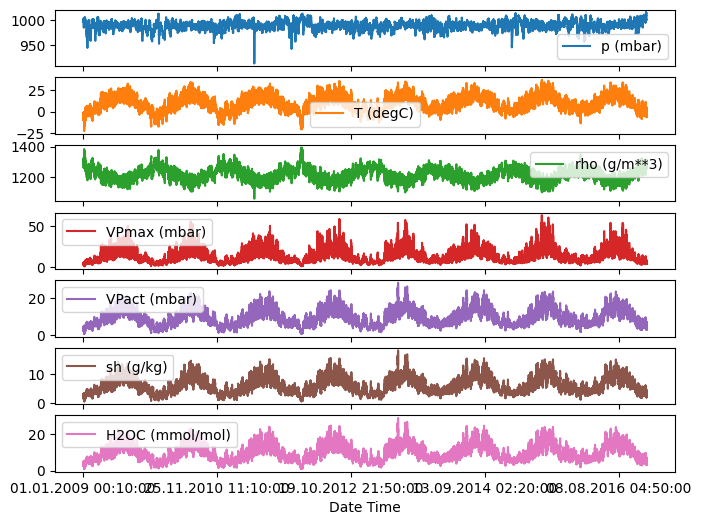

In [ ]:
features.plot(subplots=True)

In [ ]:
TRAIN_SPLIT = 300000

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
# future_target = 72 #12 hrs, observation every 10 minutes
# 6, 8, 12, 24 hrs -> 36, 48, 72, 144
targets = [36, 48, 72, 144]
STEP = 6
models = []
histories = []

In [ ]:
for future_target in targets:
  x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                  future_target, STEP)
  x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                              TRAIN_SPLIT, None, past_history,
                                              future_target, STEP)
  BATCH_SIZE = 256
  BUFFER_SIZE = 10000

  train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
  train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
  val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

  multi_step_model = tf.keras.models.Sequential()
  multi_step_model.add(tf.keras.layers.LSTM(32,
                                            return_sequences=True,
                                            input_shape=x_train_multi.shape[-2:]))
  multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
  multi_step_model.add(tf.keras.layers.Dense(future_target))

  multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

  EPOCHS = 20
  EVALUATION_INTERVAL = 200
  multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=50)

  hrs = future_target/6
  path_name = "my_saved_lstm_" + str(hrs) + "hrs.keras"
  multi_step_model.save(path_name)
  models.append(multi_step_model)
  histories.append(multi_step_history)


Epoch 1/20


c:\Users\YogaX1G2\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 335ms/step - loss: 0.6529 - val_loss: 0.2959
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 340ms/step - loss: 0.3297 - val_loss: 0.2494
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 372ms/step - loss: 0.2996 - val_loss: 0.2669
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - loss: 0.2024 - val_loss: 0.2139
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 420ms/step - loss: 0.1551 - val_loss: 0.1631
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 104s 521ms/step - loss: 0.1647 - val_loss: 0.1699
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 514ms/step - loss: 0.1599 - val_loss: 0.1478
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 523ms/step - loss: 0.1523 - val_loss: 0.1638
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 523ms/step - loss: 0.1547 - val_loss: 0.1266
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 524ms/step - loss: 0.1499 - val_loss: 0.1497
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1788s 9s/step - loss: 0.1295 - val_loss: 0.1144
Epoch 12/20
200/200 ━━━━━━

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 7)

 Target temperature to predict : (72,)


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

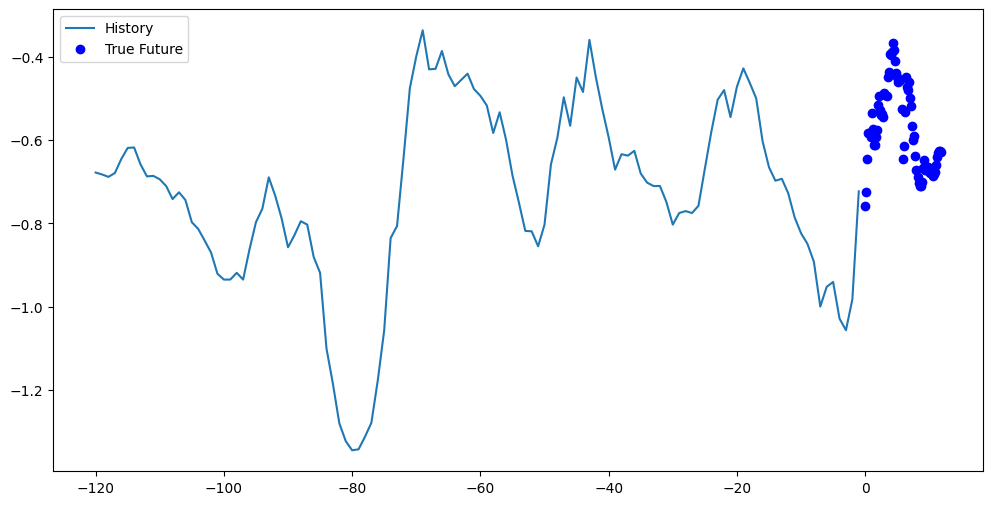

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 19ms/step
(256, 72)


Epoch 1/10
200/200 [==============================] - 33s 165ms/step - loss: 3.4126 - val_loss: 0.2372
Epoch 2/10
200/200 [==============================] - 34s 171ms/step - loss: 0.2374 - val_loss: 0.2040
Epoch 3/10
200/200 [==============================] - 35s 174ms/step - loss: 0.2227 - val_loss: 0.1955
Epoch 4/10
200/200 [==============================] - 33s 165ms/step - loss: 0.2093 - val_loss: 0.1893
Epoch 5/10
200/200 [==============================] - 34s 170ms/step - loss: 0.1816 - val_loss: 0.1903
Epoch 6/10
200/200 [==============================] - 35s 174ms/step - loss: 0.1951 - val_loss: 0.1927
Epoch 7/10
200/200 [==============================] - 33s 164ms/step - loss: 0.1904 - val_loss: 0.1966
Epoch 8/10
200/200 [==============================] - 33s 165ms/step - loss: 0.1867 - val_loss: 0.1811
Epoch 9/10
200/200 [==============================] - 34s 171ms/step - loss: 0.1930 - val_loss: 0.1801
Epoch 10/10
200/200 [==============================] - 33s 164ms/step - l

In [ ]:
multi_step_model.save('lstm.h5')
multi_step_model.save('lstm')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
model_path = "my_saved_lstm_6.0hrs.keras"
# Ładowanie modelu
model = load_model(model_path)


In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

NameError: name 'multi_step_history' is not defined

8/8 [==============================] - 1s 28ms/step


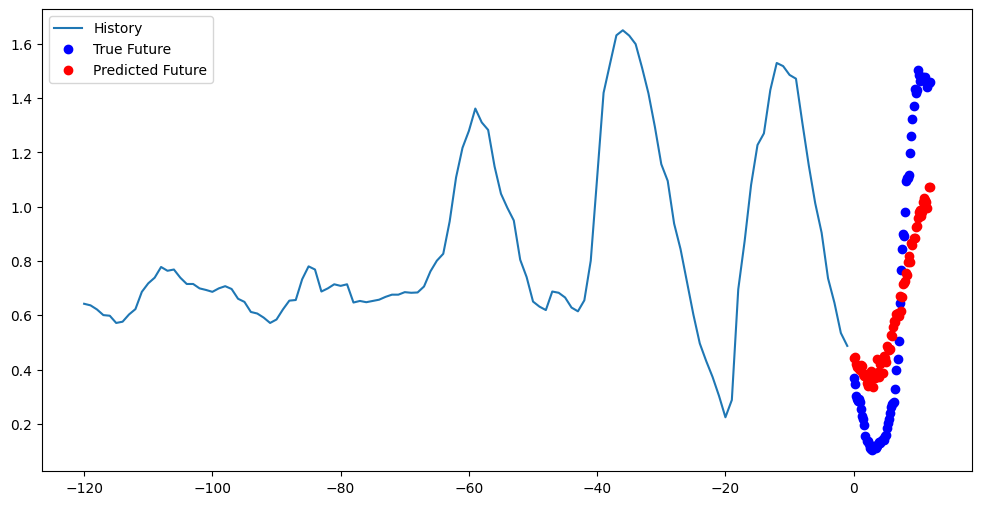

8/8 [==============================] - 0s 29ms/step


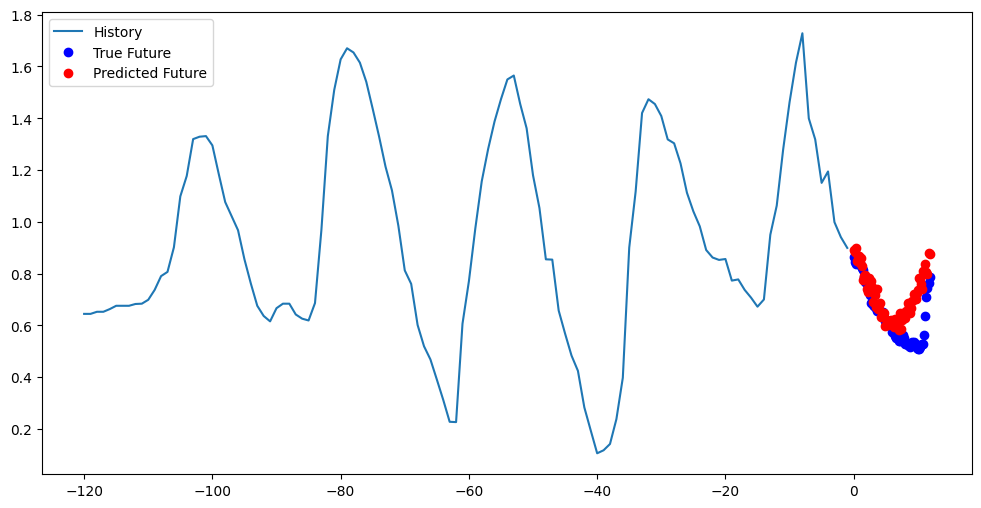

8/8 [==============================] - 0s 35ms/step


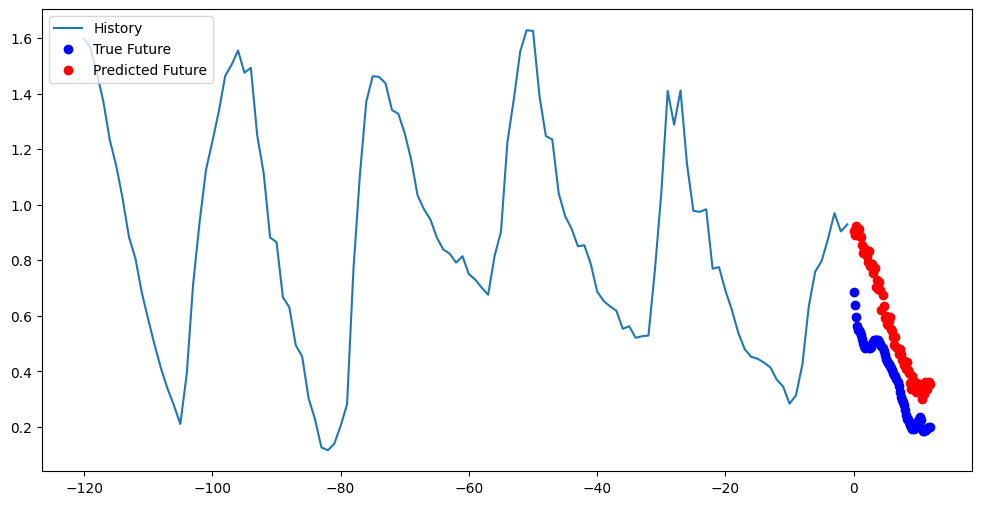

In [ ]:
for x, y in val_data_multi.take(3):

  multi_step_plot(x[0], y[0], model.predict(x)[0])